![Logo.png](assets/Logo.png)


Tutorial Group: 	T01 Group 4 <br>

Student Name 1:	Ryan Liam Poon Yang<br>
Student Number: 	S10222131E <br>
Student Name 2:	Teh Zhi Xian<br>
Student Number: 	S10221851J<br>
Student Name 3:	Chuah Kai Yi<br>
Student Number: 	S10219179E<br>
Student Name 4:	Don Sukkram<br>
Student Number: 	S10223354J<br>
Student Name 5:	Darryl Koh<br>
Student Number: 	S10221893J<br>



#### 1. [Setup](#0) 
   - [1.1 Import Packages](#1.1)  
   - [1.2 Connect to Snowflake](#1.2) 
   - [1.3 Gathering Data as Snowpark DataFrame](#1.3)

#### 2. [Data Exploration](#1)
   - [2.0.1 Model Value Towards Tasty Byte KPI](#2.01)
   - [2.1 K-Means Clustering](#2.1)  
      - [2.1.1 Joining the Data](#2.1.1)  
         - [2.1.1.1 Define function - Remove Duplicate Columns from Joins](#2.1.1.1)  
         - [2.1.1.2 Join Members Data with Orders_V](#2.1.1.2)  
      - [2.1.2 Generate RFN table (K-Means Specific)](#2.1.2)  
      - [2.1.3 Outlier Handling (K-Means Specific)](#2.1.3)  
      - [2.1.4 Feature Scaling (K-Means Specific)](#2.1.4)  
      - [2.1.5 Building K-Means model](#2.1.5)  
      - [2.1.6 Improving the K-Means model](#2.1.6)  
   - [2.2 Visualise the Data](#2.2) 
      - [2.2.1 K-Means Clusters](#2.2.1) 
      - [2.2.2 Total number of Transactions](#2.2.2) 
      - [2.2.3 Members in Country](#2.2.3) 
      - [2.2.4 Total number of Transactions](#2.2.4) 
   - [2.3 Churn Rate by Country](#2.3) 
      - [2.3.2 Calculate Churn Rate by Country](#2.3.2)
      - [2.3.3 Visualise Churn Rate](#2.3.0)

#### 3. [Data Engineering](#3)
   - [3.1 Generate new Columns](#3.1)  
      - [3.1.1 Get Latest Order Date](#3.1.1)
      - [3.1.2 RFM (Recency, Freqency, Monetary)](#3.1.2)
      - [3.1.3 Average Time Difference, Max and Min Days without Purchase](#3.1.3)
      - [3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country](#3.1.4)
      - [3.1.5 Join Generated Variables](#3.1.5)
      - [3.1.6 Days to Next Order](#3.1.6)
      - [3.1.7 Filter to selected Country](#3.1.7)
   - [3.2 Outlier Handling](#3.2)  
      - [3.2.1 Identify Numericals](#3.2.1)
      - [3.2.2 Visualise Outliers](#3.2.2)
      - [3.2.3 Cap the Outliers](#3.2.3)
         - [3.2.3.1 Cap by IQR](#3.2.3.1)
         - [3.2.3.2 Cap by Gaussian](#3.2.3.2)
   - [3.3 Numerical Transformation](#3.3)
      - [3.3.1 Visualise Numericals](#3.3.1)
      - [3.3.2 YeoJohnson Transformer](#3.3.2)
   - [3.4 Generate Target Variable](#3.4)
   - [3.5 Sample the Data](#3.5)
      - [3.5.1 Stratified Sampling](#3.5.1)

#### 4. [Split the Data](#3)
   - [4.1 Data Engineering 2](#4.1)  
      - [4.1.1 Categorical Encoding](#4.1.1)
         - [4.1.1.1 One Hot Encoding](#4.1.1.1)
         - [4.1.1.2 Clean the Encoded Columns](#4.1.1.2)
      - [4.1.2 Feature Scaling](#4.1.2)
         - [4.1.2.1 Min Max Scaler](#4.1.2.1)
      - [4.1.3 Drop Target Variable](#4.1.3)  

#### 5. [Model Building](#5) 
   - [5.1 Define Evaluation Function](#5.1)  
   - [5.2 Logistic Regression](#5.2)
      - [5.2.1 Build the model](#5.2.1)
      - [5.2.2 Improve the model](#5.2.2)
   - [5.3 Decision Tree](#5.3)
      - [5.3.1 Build the model](#5.3.1)
      - [5.3.2 Improve the model](#5.3.2)
   - [5.4 Random Forest](#5.4)
      - [5.4.1 Build the model](#5.4.1)
      - [5.4.2 Improve the model](#5.4.2)
   - [5.5 Adaboost](#5.5)
      - [5.5.1 Build the model](#5.5.1)
      - [5.5.2 Improve the model](#5.5.2)
   - [5.6 XGboost (Final Model)](#5.6)
      - [5.6.1 Build the model](#5.6.1)
      - [5.6.2 Improve the model](#5.6.2)
   
#### 6. [Model Comparison](#6)
   - [6.1 Model Accuracies](#6.1)  

#### 7. [Machine-Learning with Snowflake ](#7) 
   - [7.1 Create the Stage ](#7.1)  
   - [7.2 Create Tables](#7.2)  
   - [7.3 Create Final Model ](#7.3) 
   - [7.4 Model Training](#7.4)
   - [7.5 Model Deployment](#7.5)
      - [7.5.1 Create a User-Defined Function for Model Inference](#7.5.1) 
      - [7.5.2 Run UDF](#7.5.2) 
         - [7.5.2.1 Evaluation](#7.5.2.1)


# Overview
We are part of the data team at Snowflake. Snowflake is a provider of cloud-based data platform based in Singapore that offers scalable, cloud-based data processing, analytics and machine learning services that can integrate with a wide range of other tools enabling users to build and deploy models for predictive analytics and AI applications. 

The customer is Tasty Bytes, one of the largest food truck networks in the world with localized menu options spread across 30 major cities in 15 countries. In the inception deck, we have identified the following pain points: 

●   Member Churn is quite high, at ~33% of all members churned over a 3 year period<br>
●   Member Churn is at ~50% in a 1 month period<br>
●   Membership sign up growth is stagnant with no upward trend<br>

This means that Tasty Bytes has a unsustainable churn rate and may result in market shrinkage in the future. Moreover, their long term goals are as follows:

![tasty_byte_goals.jpg](assets/tasty_byte_goals.jpg)

For our Proof of Concept (POC), we will be focusing on the Sales and NPS metrics in particular

![tasty_byte_goals_focus.jpg](assets/tasty_byte_goals_focus.jpg)

To help Tasty Bytes address their pain points and reach their goals, we have come up with a solution, which will be to create a user-friendly customer analytics platform that provides key insights on member behavior to improve retention and drive growth. 

To accomplish this, the following steps will be taken

●   Create an unsupervised learning model to segment our members<br>
●   Create a Churn Prediction Model to identify members who are at risk of ending their relationship with the company<br>
●   Integrate the Machine-Learning model and key visualizations into streamlit web application<br>

In this juypter notebook, we will be creating an unsupervised learning model to segment Tasty Byte's members and a classification model to predict member's churn

# 1. Setup

## 1.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import classification_report

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("frostbyte_tasty_bytes_setup_s.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("frostbyte_tasty_bytes_setup_s.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

### 2.0.2 Model Value Towards Tasty Byte KPI

The initial objectives of the model is to work towards improving two main KPI's. This section includes information regarding the correlation of identifying customer churn (or in the case of this stage, days to next order).

The idea behind our model is that by identifying when customers will churn the marketing team can take steps to carry out targeted marketing to be able to prevent that and in turn improve NPS score and Sales YOY

In [6]:
# gather NPS required columns to analyse
SENTIMENT = TRUCK_DATA.join(SENTIMENT_DATA, SENTIMENT_DATA["TRUCK_ID"] == TRUCK_DATA["TRUCK_ID"], "inner")

SENTIMENT2 = SENTIMENT.dropna()

# setting up NPS Score by year, month and specific year months to compare
AVG_NPS_SCORE = SENTIMENT2.with_column("YEAR", F.year("SURVEY_TS"))
AVG_NPS_SCORE = AVG_NPS_SCORE.with_column("MONTH", F.month("SURVEY_TS"))
AVG_NPS_SCORE = AVG_NPS_SCORE.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

AVG_NPS_SCORE_YEAR = AVG_NPS_SCORE.groupBy(F.col("YEAR")).agg(F.avg("NPS_SCORE"))
AVG_NPS_SCORE_MONTH = AVG_NPS_SCORE.groupBy(F.col("MONTH")).agg(F.avg("NPS_SCORE"))
AVG_NPS_SCORE_YM = AVG_NPS_SCORE.groupBy(F.col("YEAR"), F.col("MONTH")).agg(F.avg("NPS_SCORE"))

# setting up comparison table (i.e. DTNO to KPI)
NPS_COMPARE = NPS_COMPARE.with_column("YEAR", F.year("DATE"))
NPS_COMPARE = NPS_COMPARE.with_column("MONTH", F.month("DATE"))
NPS_COMPARE = NPS_COMPARE.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

AVG_DTNO_YEAR = NPS_COMPARE.groupBy(F.col("YEAR")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))
AVG_DTNO_MONTH = NPS_COMPARE.groupBy(F.col("MONTH")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))
AVG_DTNO_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))

AVG_SALES_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.avg('"ORDER_TOTAL"'))
SUM_SALES_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.sum('"ORDER_TOTAL"'))

Here we are comparing the average days to next order, which is what our model is predicting for in terms of the churn value, with the average net promoter score of the respective year. We can see that there exists a correlation that does not fit what we had set out to achieve.

There is a positive correlation between the two values across the years and that is reflected as well when taking a look at the month and year month levels (Which is not shown in the jupyter notebook).

It is expected that the two values do not have the correlation that we were looking for and hence we will be dropping the NPS as our target for this model due to this finding.

In [7]:
# comparing the NPS with the DTNO VALUE
DTNO_TO_NPS_YEAR = AVG_DTNO_YEAR.join(AVG_NPS_SCORE_YEAR, AVG_DTNO_YEAR["YEAR"] == AVG_NPS_SCORE_YEAR["YEAR"])

SDTNO_TO_NPS_YEAR_LOW_COL = remove_dup_join_col(DTNO_TO_NPS_YEAR)

SDTNO_TO_NPS_YEAR_LOW_COL.show()

----------------------------------------------------------
|"AVG(DAYS_TO_NEXT_ORDER)"  |"YEAR"  |"AVG(NPS_SCORE)"   |
----------------------------------------------------------
|16.843626                  |2021    |70.78996630475477  |
|24.773306                  |2020    |82.65104808877929  |
|12.569290                  |2022    |73.91523935002196  |
|43.885027                  |2019    |89.78290366350068  |
----------------------------------------------------------



On the other hand we do see that the average days to next orders has a relationship with average sales by month that we can work with.

We see that when the average days to next orders increase the total sales within the month decrease, and when average days to next orders decrease the total sales increase this means the customer recursion matters to the revenue.

This acts as a proxy value to the KPI of revenue and ties our models output towards achieving company goals. As by taking actions to reduce the days to next order or churn rate down we can maximise our profits through creating loyal customers and encouraging customers to use the service more.

In [8]:
SALES_VS_DTNO = SUM_SALES_YM.join(AVG_DTNO_YM, (SUM_SALES_YM["YEAR"] == AVG_DTNO_YM["YEAR"])&(SUM_SALES_YM["MONTH"] == AVG_DTNO_YM["MONTH"]))

SALES_VS_DTNO_LOW_COL = remove_dup_join_col(SALES_VS_DTNO)

SALES_VS_DTNO_LOW_COL.orderBy(F.col('YEAR'),F.col('MONTH').asc()).show()

---------------------------------------------------------------------
|"SUM(ORDER_TOTAL)"  |"YEAR"  |"MONTH"  |"AVG(DAYS_TO_NEXT_ORDER)"  |
---------------------------------------------------------------------
|2076.5000           |2019    |1        |118.851852                 |
|20881.5000          |2019    |2        |108.026820                 |
|90080.0000          |2019    |3        |92.850471                  |
|213301.5000         |2019    |4        |77.666835                  |
|456734.5000         |2019    |5        |67.769028                  |
|690292.5000         |2019    |6        |59.439070                  |
|1131622.0000        |2019    |7        |53.820388                  |
|1646242.5000        |2019    |8        |46.346572                  |
|1989693.0000        |2019    |9        |43.228522                  |
|2462334.0000        |2019    |10       |41.197837                  |
---------------------------------------------------------------------



## 2.1 K-Means Clustering

### 2.1.1 Joining the Data

#### 2.1.1.2 Join Members Data with Orders_V

In [9]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [10]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

In [11]:
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"            |"FRANCHISE_FL

### 2.1.2 Generate RFM table (K-Means Specific)

In [12]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = remove_dup.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = remove_dup.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = remove_dup.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

In [13]:
#Convert RFM Table to pandas and drop ORDER_TS
X=RFM_table.to_pandas()
X=X.drop(['ORDER_TS','CUSTOMER_ID'],axis=1,errors='ignore')
X.head()

,RECENCY,FREQUENCY,MONETARY
0,11,76,3014.75
1,20,41,1686.00
2,2,63,2208.25
3,4,42,1823.00
4,34,54,2142.25


### 2.1.3 Outlier Handling (K-Means Specific)

<b>Outlier handling increased the models inertia/SSE, therefore it is in markdown.

#create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(X)
X_win = windsorizer.transform(X)

#create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY'])

windsorizer.fit(X_win)
X_win=windsorizer.transform(X_win)

### 2.1.4 Feature Scaling (K-Means Specific)

In [14]:
# Scaling the data so that all the features/attributes become comparable 
MinMax = MinMaxScaler()
X_scaled_MinMax=MinMax.fit_transform(X)


### 2.1.5 Building K-Means model

In [15]:
#Build kmeans for min max scaled data
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

2859.3105537979745

### 2.1.6 Improving the K-Means model

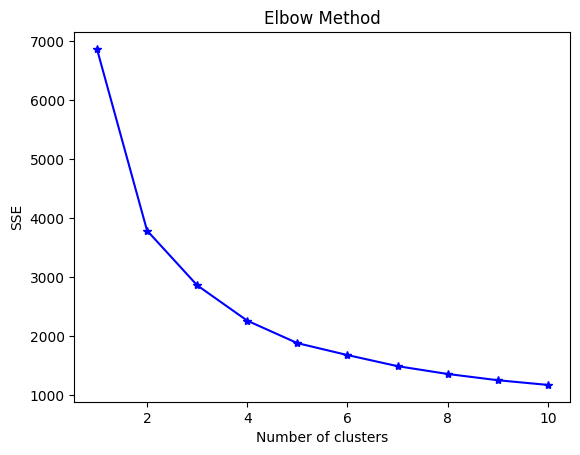

In [16]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(X_scaled_MinMax)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

1878.7849456532256

## 2.2 Visualise the Data

### 2.2.1 K-Means Clusters

RECENCY


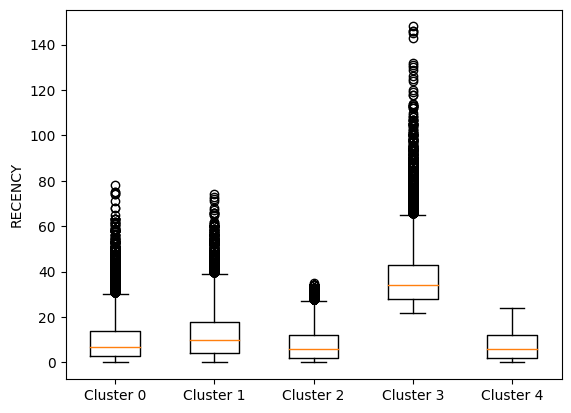

FREQUENCY


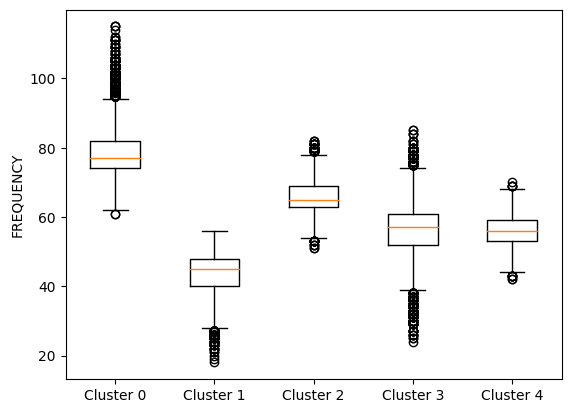

MONETARY


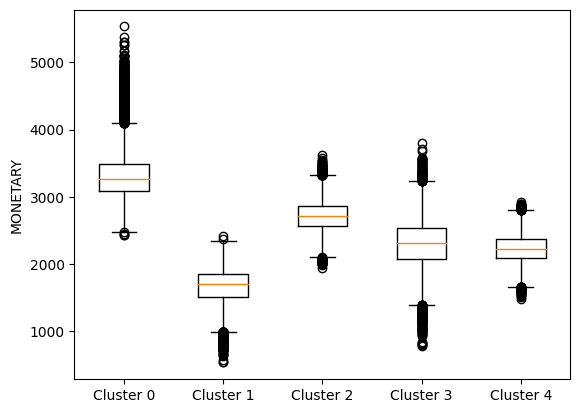

Cluster


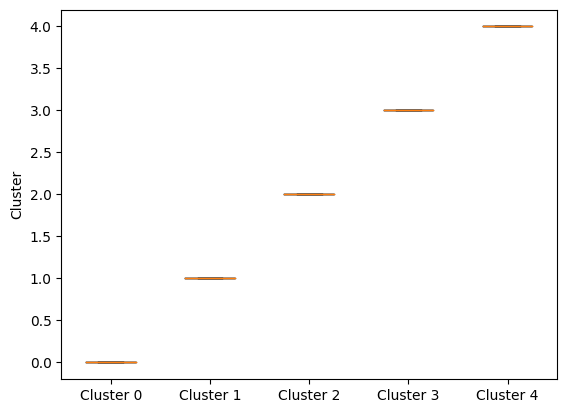

In [18]:
y_pred = kmeans.fit_predict(X_scaled_MinMax)

X['Cluster']=y_pred

# Groupped Boxplots
col_index = 0

for col in X: 
    
    boxplots = []
    clustername = []

    for cluster_index in range(X['Cluster'].nunique()):
        boxplots.append(X.iloc[:,col_index][X.Cluster==cluster_index].tolist())
        clustername.append('Cluster ' + str(cluster_index))
        
    print(col) 
    plt.cla()
    plt.ylabel(col)
    plt.boxplot(boxplots,
                 labels=clustername)    
    plt.show()
    col_index=col_index+1

Using the customer segmentation model we are able to identify what groups the customers fall under so as to be able to better provide them with targeted marketing. This in turn could mean better marketing strategies which will better capitalise on the results from the machine learning models predictions. Targeted marketing is important in improving the chances that customers will respond to the marketing strategy.

For example
In the above lookinng at cluster 0 are our frequent customers who spend an average amount of money are our potentially growable customers who could turn into big spenders. Identifying when these customers will churn and understanding that they are of this category could help us take action to retain these customers and perhaps convert them up.

Cluster 2 is our big spenders who often frequent the store and come have a low recency value, these customers are the most valuable and when they churn the company could lose lots of revenue and being able to identify when they will churn could allow us to take pre-emptive measures to retain them.

### 2.2.2 Members in Country

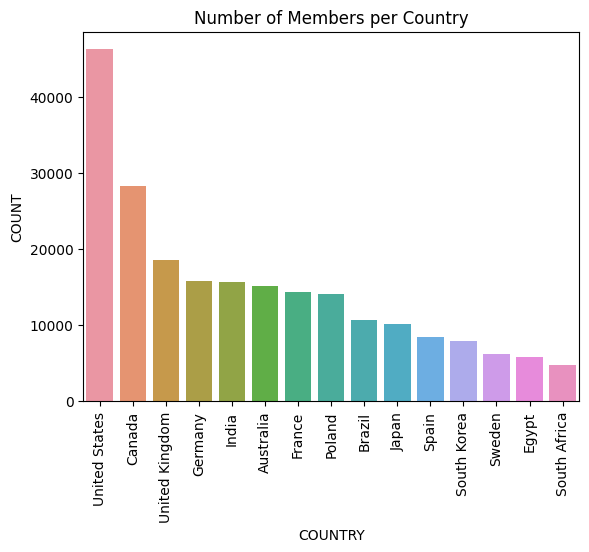

In [19]:
# Unique members
unique_Members=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=unique_Members)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

It can be seen that the Unite States has the most number of members of all the countries Tasty Bytes serves. By choosing the United States, we will have the largest possible sample size of members to most closely mimic a global dataset.

### 2.2.3 Total number of Transactions

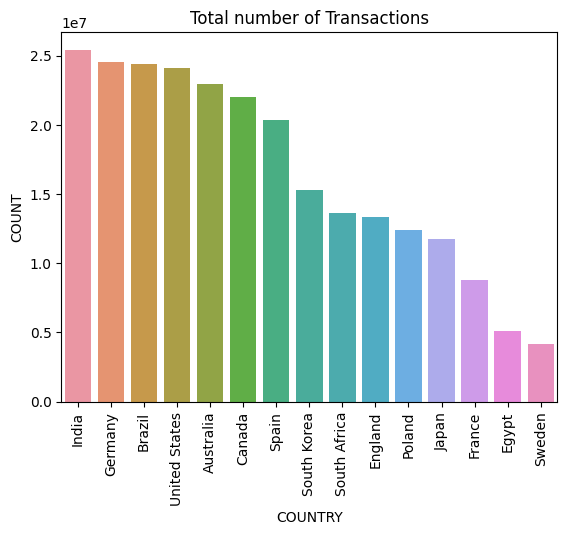

In [20]:
# Number of unique transactions
unique_Transactions=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=unique_Transactions)
plt.xticks(rotation=90)
plt.title('Total number of Transactions')
plt.show()

It can be seen that the United States has the 4th most number of transactions. We are able to get a balance of the number of members with sufficent data on each member from their orders

## 2.3 Churn Rate by Country

### 2.3.1 Get Churn Cut Off date by Country

In [21]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)

We get the churn cut off date by country. This is done by subtracting 14 days from the latest order date, with 14 days being the assumed churn period. These values are compared with the time stamp so that we can identify which customers were active within the time frame and how many left. 

### 2.3.2 Calculate Churn Rate by Country

In [22]:
#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
churn_Rate=calc.sort_values(by='CHURN_RATE',ascending=False)

We calculated the churn rate for each country. This is done by calculating the number of customers at the start and end of churn period. After doing so, the churn rate is grouped by the different countries.

### 2.3.3 Visualise Churn Rate

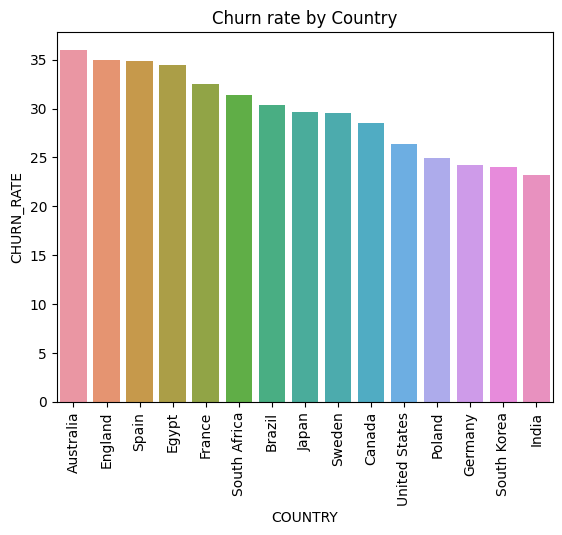

In [23]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=churn_Rate)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

### 3.1.1 Get Latest Order Date

In [24]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

# Get the second and third last orders of each customer
second_max_order_ts = orders_with_rank.filter(F.col('rank') == 2).select('customer_id', 'order_ts').withColumnRenamed('ORDER_TS','Second_Max_Order_TS')
third_max_order_ts = orders_with_rank.filter(F.col('rank') == 3).select('customer_id', 'order_ts').withColumnRenamed('ORDER_TS','Third_Max_Order_TS')

In [25]:
# Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [26]:
# Merge with second max order dataframe
max_Order=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = max_Order.filter(F.col('ORDER_TS') < F.col('Max_Order_TS'))


In [27]:
# Display last recorded purchase globally
tasty_bytes_orders_v.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



We got the latest order date to filter out the last purchase and its also used to get the days to next order. Since our target variable is closely related to the days to next order, we filter out the last purchase to not leak future information such that we are able to prevent target leakage.

### 3.1.2 RFM (Recency, Freqency, Monetary)

In [28]:
# Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

This code is used to get RFM, Recency, Frequency, and Monetary for each customer. The purpose of doing this is to generate new features and show the customer's behavioural data.

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [29]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

# Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

This code is used to get the average purchase time difference for each customers. This is done by calculating the most number of days a customer has gone without purchasing and the least number of days the customer has gone without purchasing. These features are also to show the behavioural information of each customer.

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [30]:
tasty_bytes_customer_loyalty.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

In [31]:
# Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY','SIGN_UP_DATE')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

#get TENURE variable
#cust_demo=cust_demo.withColumn('TENURE',F.datediff('year', F.col("SIGN_UP_DATE"),F.lit(lastdate)))

cust_demo.show()


-------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"      |"SIGN_UP_DATE"  |"AGE"  |
-------------------------------------------------------------------------------------------------------------
|66             |1982-11-24       |Male         |Married           |Canada         |2019-10-08      |40     |
|118            |1988-06-13       |Male         |Single            |United States  |2019-07-07      |34     |
|131            |1984-12-29       |Male         |Single            |Canada         |2021-05-27      |38     |
|132            |1981-04-30       |Male         |Single            |Canada         |2020-11-10      |41     |
|171            |1987-08-06       |Male         |Single            |Canada         |2021-05-08      |35     |
|189            |1984-03-05       |Undisclosed  |Married           |United States  |2020-03-06      |38     |
|195      

We added a new column called "AGE" which contains the age of the customer at the time of the latest transaction. We also retrieved new columns like the customer's gender, marital status and country.

### 3.1.5 Join Generated Variables

In [32]:
# Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')

We joined all the different tables to get all the columns in the same table by inner joining all the different tables on the CUSTOMER_ID column. The joined table contains all the different features we will be using to predict the target.

### 3.1.6 Days to Next Order

In [33]:
# Convert timestamp to date such that Days to next orders is more accurate
final_df=final_df.with_column('ORDER_TS',F.to_date(F.col('ORDER_TS')))
final_df=final_df.with_column('MAX_ORDER_TS',F.to_date(F.col('MAX_ORDER_TS')))

In [34]:
# Add Days To Next Order
final_df = final_df.withColumn('Days_To_Next_Order', F.datediff(col1=final_df['ORDER_TS'], col2=final_df['MAX_ORDER_TS'],part='day'))

In [35]:
# Get median of Days to next order
#final_df.select(F.median('DAYS_TO_NEXT_ORDER')).show()

We use the median number of days since the prior order for the global dataset to create a target variable that distinguishes customers who purchase below or above this median. Customers who purchase below the median will be labeled as 'Not churn', while those who purchase above the median will be labeled as 'Churn'. This approach will help us identify customers who may require retention strategies and predict their level of engagement with our business.

The median days to next order is 9 for customers from all countries, this will be used to check if our train dataset's target variable is representative of the global dataset.

### 3.1.7 Filter to selected Country

In [36]:
# Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

We filtered the data to only have records for the United States. This is because we are only interested in the United States as shown above due to its high churn rate and high number of customers

In [37]:
# Drop CustomerID
final_df=final_df.sort('CUSTOMER_ID')

We removed the CustomerID column to prevent overfitting

In [38]:
# Convert to pandas
final_df=final_df.to_pandas()

We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [39]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [40]:
# Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(12, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [41]:
# function to create before and after histogram
def before_after_histogram(df_before,df_after, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[variable], bins=30)
    plt.title('Before')

    # histogram
    plt.subplot(1, 2, 2)
    sns.histplot(df_after[variable], bins=30)
    plt.title('After')

    plt.suptitle(variable)

    plt.show()

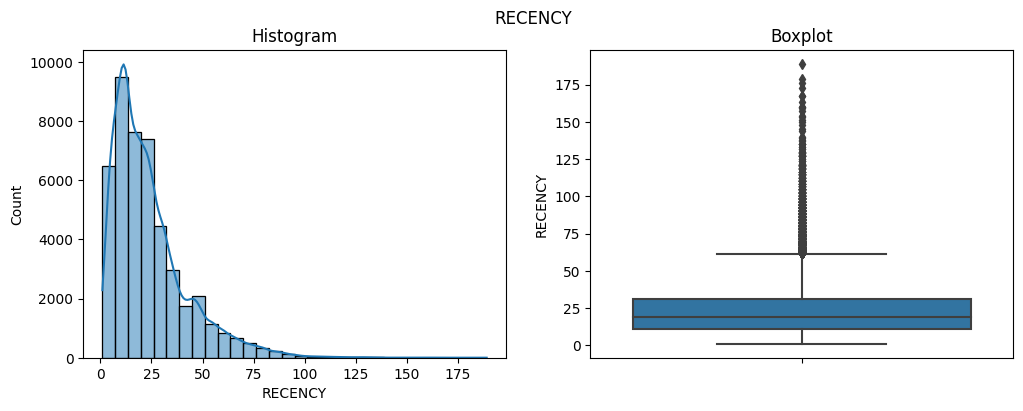

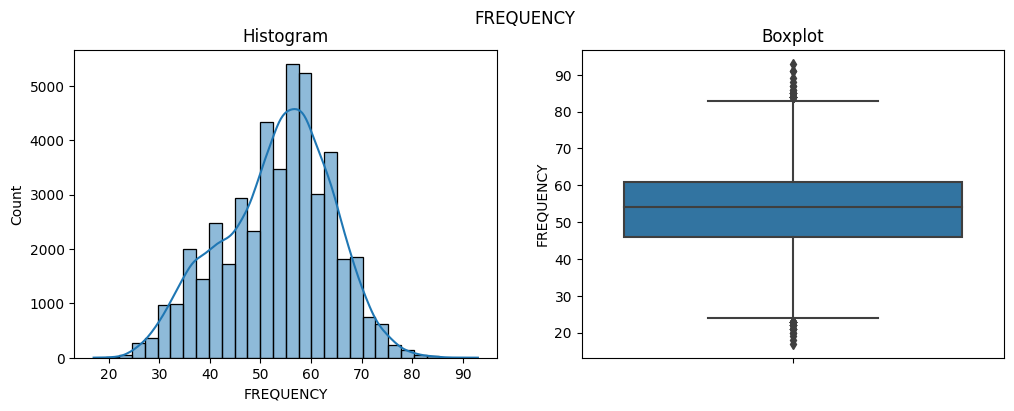

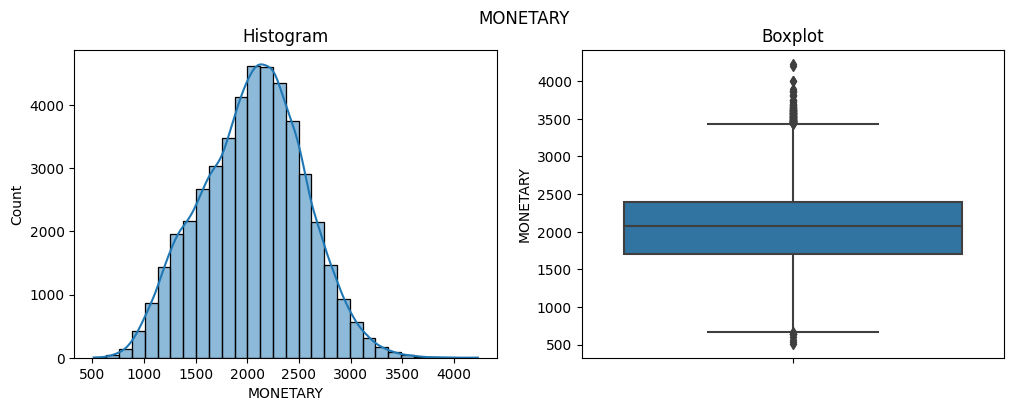

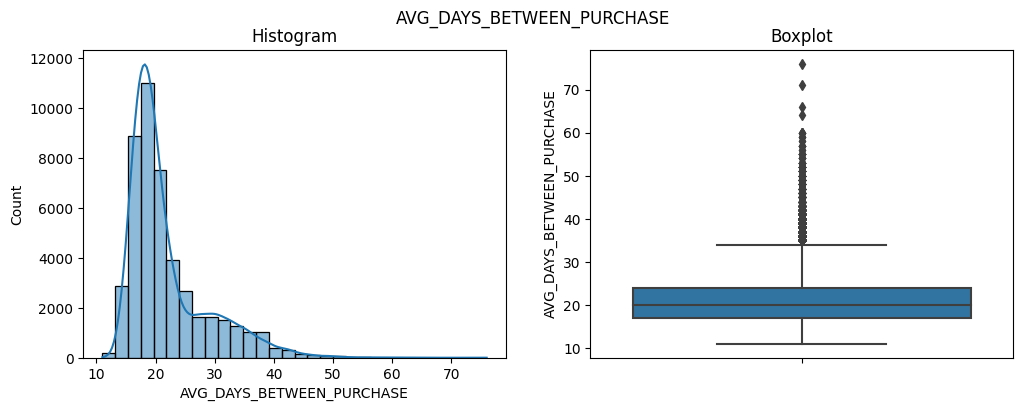

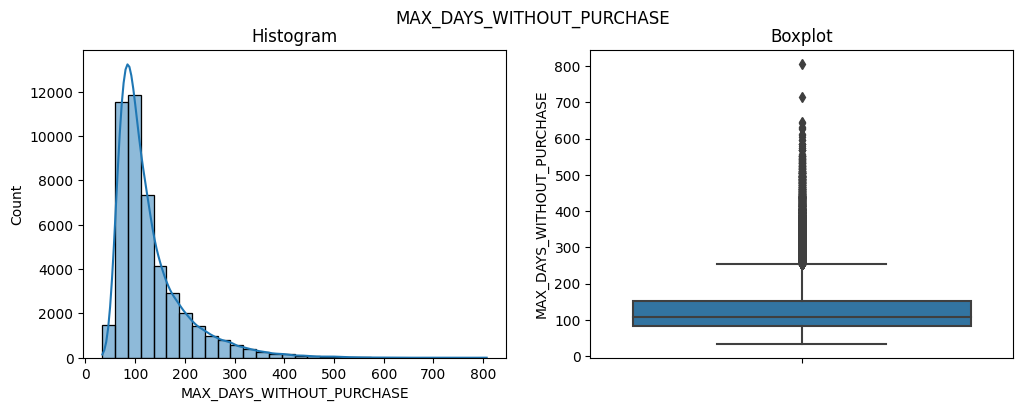

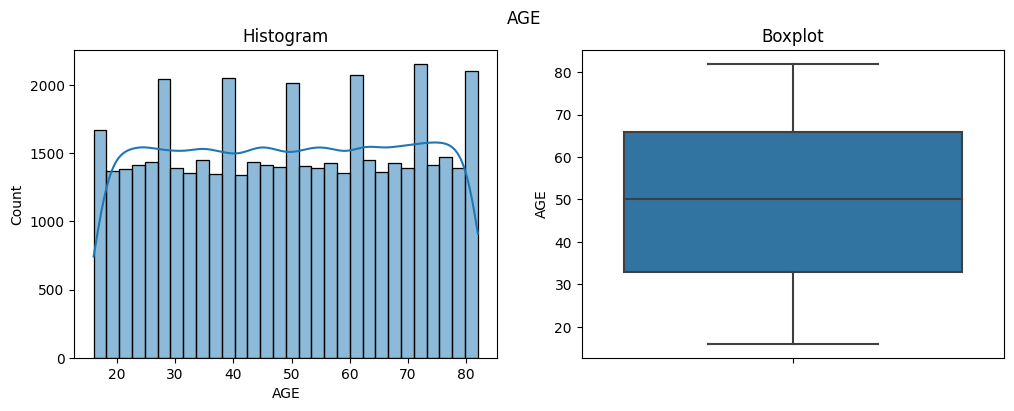

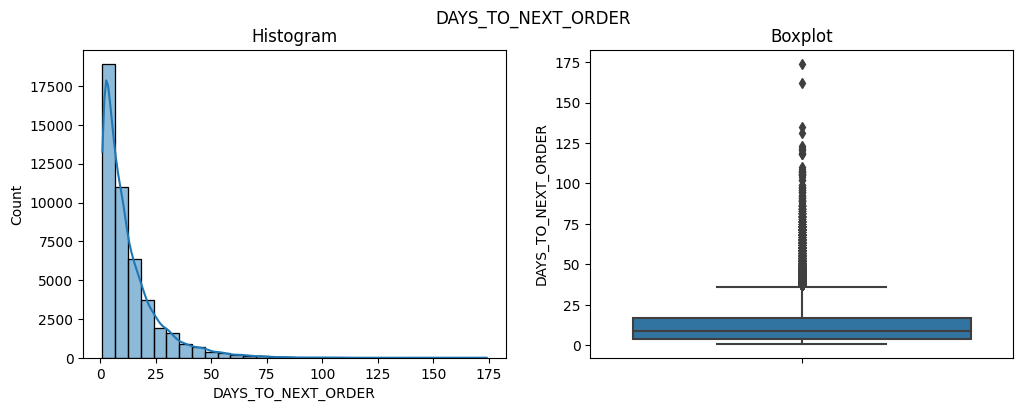

In [42]:
for i in num_cols.drop(['MIN_DAYS_WITHOUT_PURCHASE','CUSTOMER_ID']):
    diagnostic_plots(final_df,i)
    plt.show()

From the histograms, it can be seen that Recency, Average days between purchase, Maximum days without purchase and days to next order columns have a right skewed distribution. 

Frequency and Monetary have quite a normal distribution.

*Note there is no point dealing with outliers in Days to next order as even when dealt with, the 50% mark stays the same, meaning no change to our target variable.

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [43]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

In [44]:
final_df_win = windsorizer.transform(final_df)

Cap by IQR for distributions with high skewness. (Outliers = 75th percentile onwards)

#### 3.2.3.2 Cap by Gaussian

In [45]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'MONETARY'])

In [46]:
final_df_win = windsorizer.transform(final_df_win)

Cap by gaussian for distributions with a normal ditribution. (Outliers = 3 Standard-deviations away)

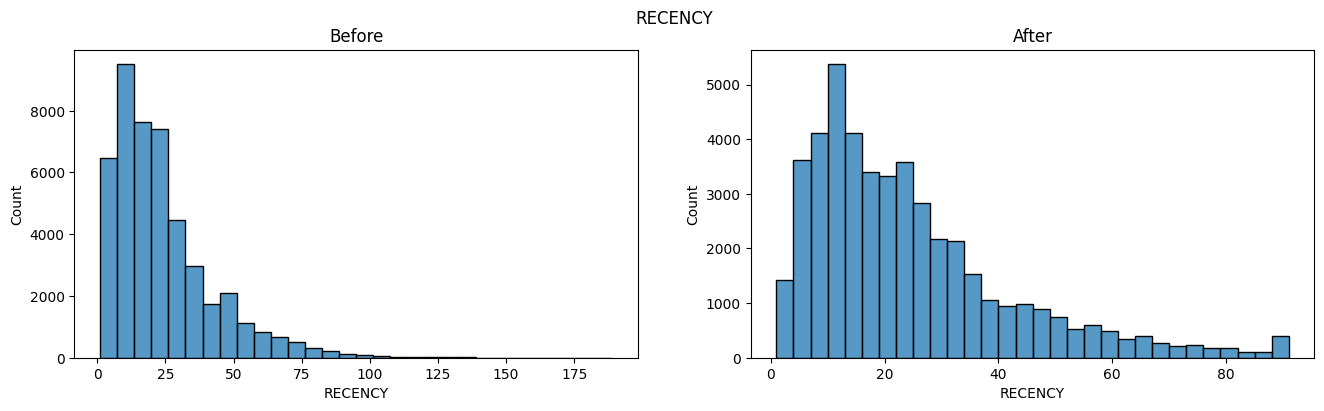

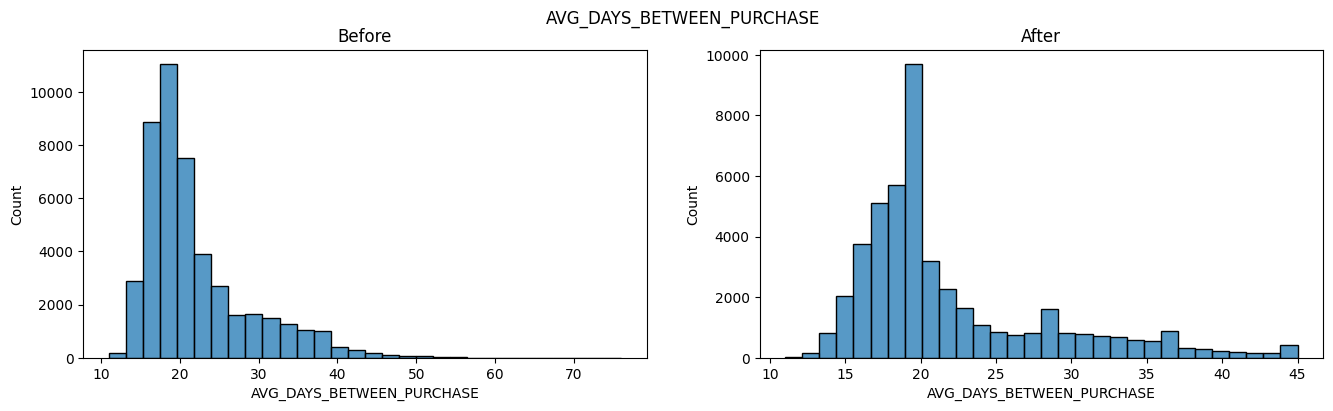

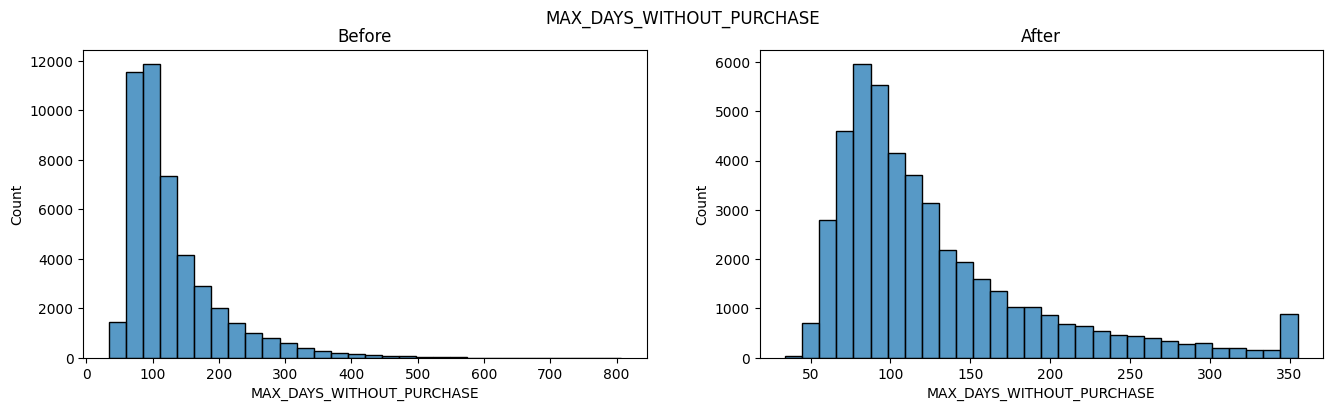

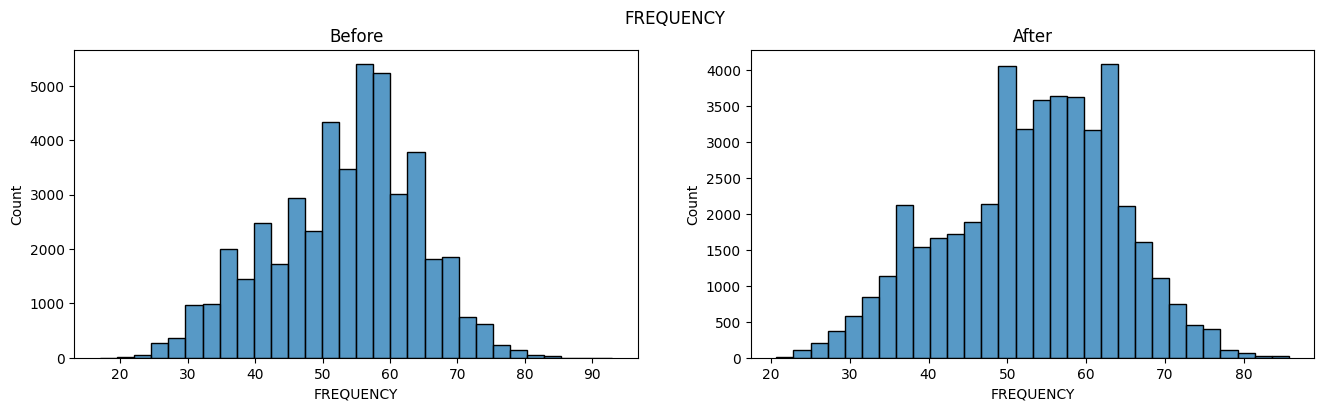

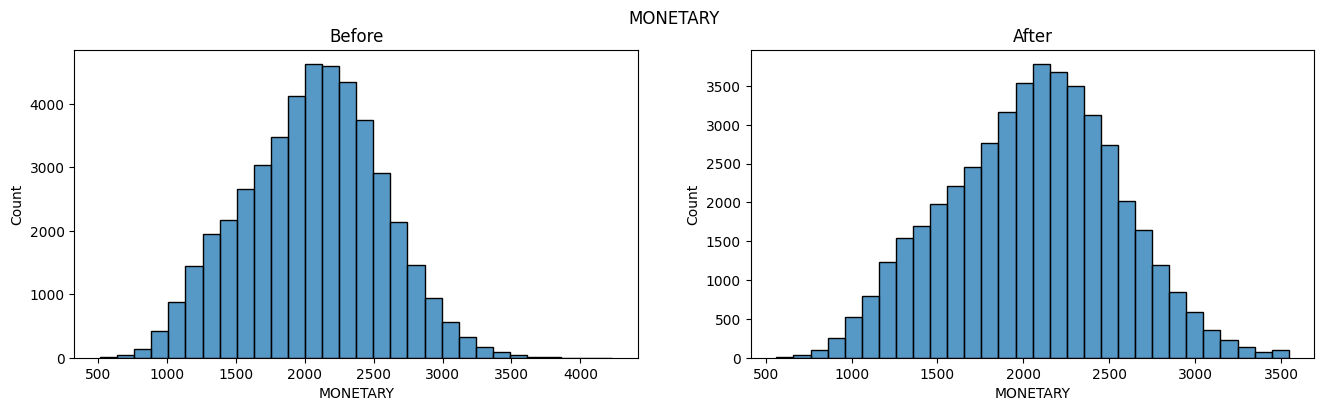

In [47]:
capped_cols = ['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE','FREQUENCY','MONETARY']

for col in capped_cols:
        before_after_histogram(final_df,final_df_win,col)

It can be seen that much of the outliers have been 'Capped' where all values above a certain threshold are placed at the uppermost limit. This ensures that the machine learning model will not be trained for anomalies and outliers but for the majority of members

We see that AVG_DAYS_BETWEEN_PURCHASE and MAX_DAYS_WITHOUT_PURCHASE has had a significant amount of outlier handling done, where the maximum values for both have been halved, down from 70 to 45 and 800 to 350 respectively.

By reducing the variable range, it helps the model focus on the key patterns and relationships within the majority of the data.

## 3.3 Numerical Transformation

### 3.3.1 Visualise Numericals

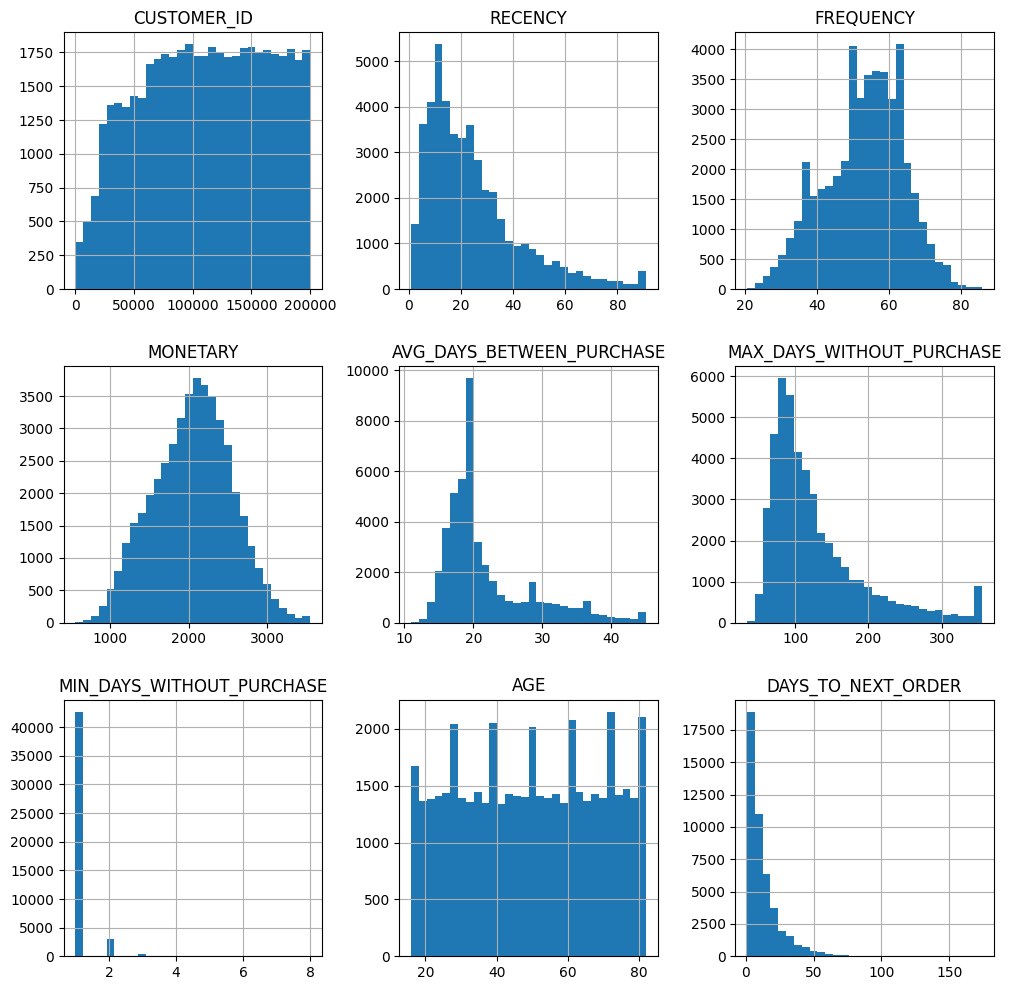

In [48]:
# plot the histogram to inspect variable distributions (not in book)

final_df_win.hist(bins=30, figsize=(12,12))
plt.show()

### 3.3.2 YeoJohnson Transformer

In [49]:
# select variables to transform in a list
cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE']

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = cols)

# fit transformer to the dataframe
yjt.fit(final_df_win)

YeoJohnsonTransformer(variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                                 'MAX_DAYS_WITHOUT_PURCHASE'])

In [50]:
# transform indicated variables
final_df_yjt = yjt.transform(final_df_win)

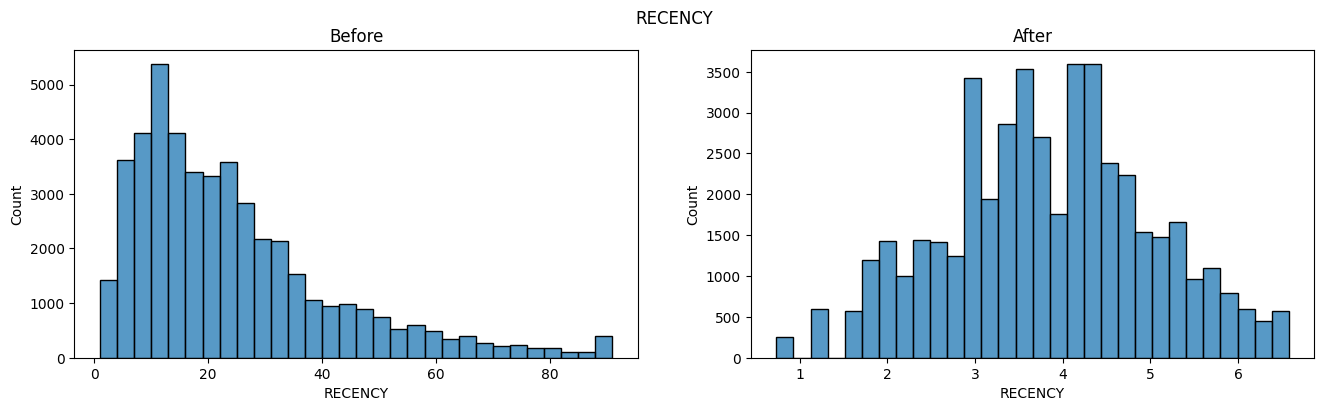

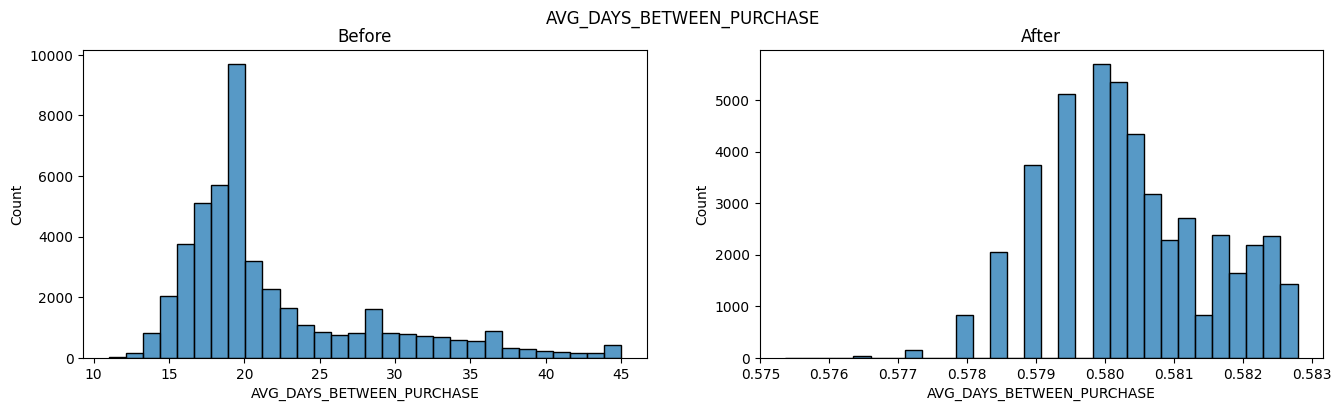

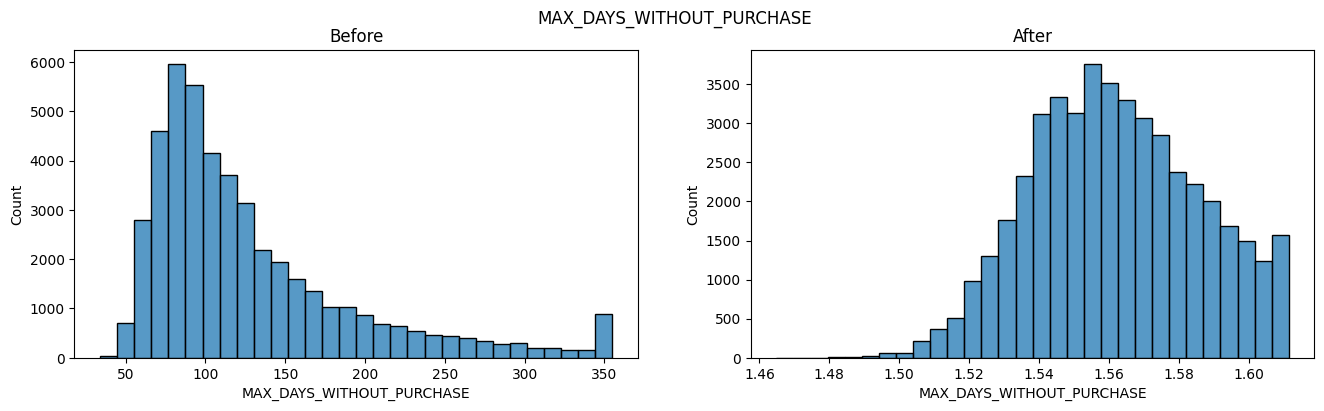

In [51]:
capped_cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE']

for col in capped_cols:
        before_after_histogram(final_df_win,final_df_yjt,col)

It can be seen that the 3 variables to be transformed have achieved a more normal distribution. This ensures that the model avoids overfitting to the random noise of the data by reducing the variable range further, as well as further mitigates the effects of outliers.

## 3.4 Generate Target Variable

In [52]:
# Describe the target
final_df_yjt['DAYS_TO_NEXT_ORDER'].describe()

count    46300.000000
mean        12.572959
std         12.840417
min          1.000000
25%          4.000000
50%          9.000000
75%         17.000000
max        174.000000
Name: DAYS_TO_NEXT_ORDER, dtype: float64

In [53]:
# Add Target CHURNED
final_df_yjt['CHURNED'] = 1
final_df_yjt.loc[final_df_yjt['DAYS_TO_NEXT_ORDER']<=9,'CHURNED'] = 0
#final_df['CHURNED'] = 1
#final_df.loc[final_df['DAYS_TO_NEXT_ORDER']<=9,'CHURNED'] = 0

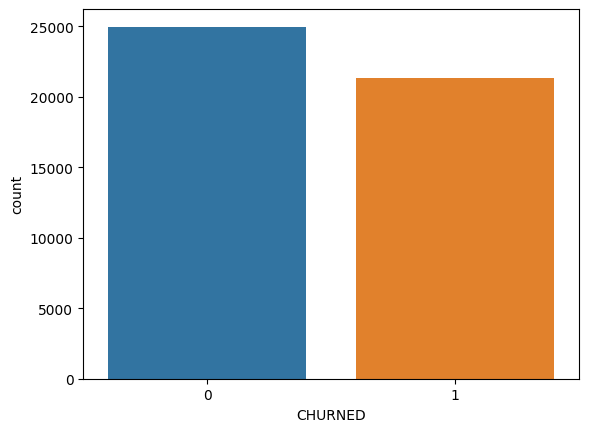

In [54]:
# Distribution of target variable
sns.countplot(data=final_df_yjt,x='CHURNED')
plt.show()

## 3.5 Sample the Data

### 3.5.1 Stratified Sampling

In [55]:
df1=final_df_yjt[final_df_yjt['CHURNED']==1]
len(df1)
#df1=final_df[final_df['CHURNED']==1]
#len(df1)

21328

In [56]:
df0=final_df_yjt[final_df_yjt['CHURNED']==0]
len(df0)
#df0=final_df[final_df['CHURNED']==0]
#len(df0)

24972

In [57]:
# Perform Stratified Sampling
df0_sampled = df0.sample(n=len(df1), random_state=4).copy()
df_new=pd.concat([df1,df0_sampled],axis=0)
df_new['CHURNED'].value_counts()

1    21328
0    21328
Name: CHURNED, dtype: int64

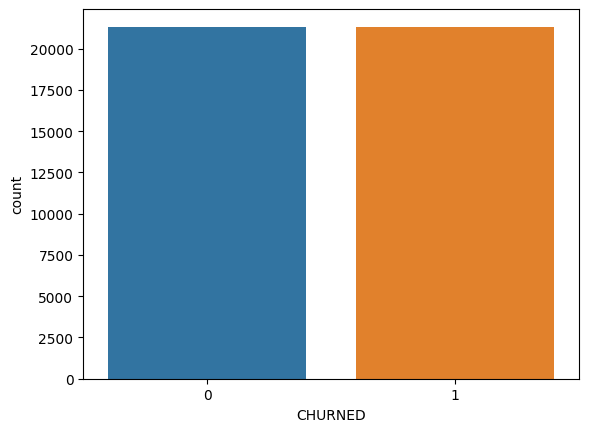

In [58]:
# Distribution of target variable
sns.countplot(data=df_new,x='CHURNED')
plt.show()

# 4 Split the Data

In [59]:
# Train test split
X = df_new.drop(['CUSTOMER_ID','DAYS_TO_NEXT_ORDER','MAX_ORDER_TS','ORDER_TS','COUNTRY','BIRTHDAY_DATE','SIGN_UP_DATE'], axis =1,
                  errors='ignore')
y = df_new["CHURNED"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)

In [60]:
# Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

## 4.1 Data Engineering 2

Data engineering needs to be done in 2 parts, one before and one after splitting the data so as to prevent data leakage to the test datasets

### 4.1.1 Categorical Encoding

#### 4.1.1.1 One Hot Encoding

In [61]:
# One Hot Encoding 
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True,
     variables=['GENDER','MARITAL_STATUS']) 

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)
X_holdout=ohe_enc.transform(X_holdout)

#### 4.1.1.2 Clean the Encoded Columns

In [62]:
X_train.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_test.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_holdout.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)

In [63]:
X_train.columns = map(str.upper, X_train.columns)
X_test.columns = map(str.upper, X_test.columns)
X_holdout.columns = map(str.upper, X_holdout.columns)

### 4.1.2 Feature Scaling

#### 4.1.2.1 Min Max Scaler

In [64]:
# Min Max Scaler

cols_to_scale=X_train.drop('CHURNED',axis=1, errors='ignore').columns

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[cols_to_scale])

# transform train and test sets
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale]= scaler.transform(X_test[cols_to_scale])
X_holdout[cols_to_scale]=scaler.transform(X_holdout[cols_to_scale])

In [65]:
# Save tables to snowflake
#session.create_dataframe(X_train).write.save_as_table(table_name="train_table", mode='overwrite')
#session.create_dataframe(X_test).write.save_as_table(table_name="test_table", mode='overwrite')
#session.create_dataframe(X_holdout).write.save_as_table(table_name="holdout_table", mode='overwrite')

### 4.1.3 Drop Target Variable

In [66]:
X_train=X_train.drop('CHURNED',axis=1, errors='ignore')
X_test=X_test.drop('CHURNED',axis=1, errors='ignore')
X_holdout=X_holdout.drop('CHURNED',axis=1, errors='ignore') 

# 5. Model Building

## 5.1 Define Evaluation Function

In [67]:
# Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):

    print('Train Accuracy: \t{:.2f}%  \
          \nTest Accuracy: \t\t{:.2f}%  \
          \nHoldout Accuracy: \t{:.2f}%'.format(model.score(X_train, y_train)*100,model.score(X_test, y_test)*100,model.score(X_holdout, y_holdout)*100))

In [68]:
# Function to show MSE, MAE, r-sq of Classification models
def evaluateModelWithName(model,model_name):
    
    print(model_name)
    print('Train Accuracy: \t{:.2f}%  \
          \nTest Accuracy: \t\t{:.2f}%  \
          \nHoldout Accuracy: \t{:.2f}%'.format(model.score(X_train, y_train)*100,model.score(X_test, y_test)*100,model.score(X_holdout, y_holdout)*100))

## 5.2 Logistic Regression

Logistic regression is a statistical method used for binary classification problems, such as problems where the response variable will be binary. Logistic regression models the relationship between the dependent variable and one or more independent variables by fitting a logistic function. It's used to predict a binary outcome based on one or more input variables, in this case, predicting if the customer will churn or not

 - is a statistical method used for predicting binary outcomes, in this case, whether a customer will churn or not
 - acts as our baseline model for this assignment

### 5.2.1 Build the model

In [69]:
# Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 	77.50%            
Test Accuracy: 		76.79%            
Holdout Accuracy: 	76.67%


### 5.2.2 Improve the model

In [70]:
# Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression()
param_grid = {"penalty": ["l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

lr_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.7744110005624726
{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


In [71]:
# Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

Train Accuracy: 	77.45%            
Test Accuracy: 		76.78%            
Holdout Accuracy: 	76.65%


## 5.3 Decision Tree

A decision tree classifier is a machine learning algorithm that creates a predictive model in the form of a tree-like structure. The model makes decisions based on a sequence of hierarchical if-else conditions applied to input features. Each internal node of the tree represents a decision based on a feature, while the leaf nodes represent the predicted outcome or class label. 

 - base model: overfitting as train accuracy is much higher than test accuracy
 - after gridsearch: reduces overfitting

### 5.3.1 Build the model

In [72]:
# Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 	95.31%            
Test Accuracy: 		70.15%            
Holdout Accuracy: 	70.66%


### 5.3.2 Improve the model

In [73]:
dt = tree.DecisionTreeClassifier()

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 
dt_best_score=gs.best_score_

print(gs.best_score_)
print(gs.best_params_)

0.7789820934987903
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [74]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 	78.36%            
Test Accuracy: 		77.06%            
Holdout Accuracy: 	77.03%


## 5.4 Random Forest

A random forest classifier is an ensemble learning algorithm that combines multiple decision trees to make predictions. It operates by constructing a multitude of decision trees during training and then aggregating their predictions to determine the final outcome. Each tree in the random forest is trained on a random subset of the training data, and the final prediction is made based on a majority vote or average of the individual tree predictions. This approach improves the model's accuracy, reduces overfitting, and allows for handling high-dimensional data. 

- base model: overfitting as train accuracy is much higher than test accuracy
- inconsistent accuracy
- after grid-search: reduces overfitting

### 5.4.1 Build the model

In [75]:
# Build Random Forest Model
random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 	100.00%            
Test Accuracy: 		76.42%            
Holdout Accuracy: 	76.43%


### 5.4.2 Improve the model

In [76]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100],
'max_depth': [ 4, 6, 8],
'min_samples_split': [5, 10, 15]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 5, n_jobs = -1)
gs = gs.fit(X_train, y_train)

rf_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.7795096776719865
{'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 100}


In [77]:
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 	78.87%            
Test Accuracy: 		77.35%            
Holdout Accuracy: 	77.35%


## 5.5 Adaboost

The AdaBoost classifier is a machine learning algorithm that combines weak learners, typically decision trees, into a strong predictive model. It works by iteratively training weak classifiers on different subsets of the training data and assigning higher weights to the misclassified samples in each iteration. This iterative process focuses on difficult instances, making subsequent weak learners prioritize them. The final prediction is determined by aggregating the weighted predictions of all the weak learners.
- base model: overfitting as train accuracy is much higher than test accuracy
- after grid-search: reduces overfitting


### 5.5.1 Build the model

In [78]:
# Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 	100.00%            
Test Accuracy: 		68.43%            
Holdout Accuracy: 	68.82%


### 5.5.2 Improve the model

In [79]:
adb = AdaBoostClassifier()

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

adb_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.7790994641892304
{'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.1, 'n_estimators': 50}


In [80]:
# Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

Train Accuracy: 	77.92%            
Test Accuracy: 		77.29%            
Holdout Accuracy: 	77.31%


## 5.6 XGboost (Final Model)

XGBoost, also known as Extreme Gradient Boosting, is a popular machine learning algorithm used for classification problems. It is an implementation of the gradient boosting framework, which can handle missing values, extreme values and large number of classes. XGBoost uses a decision tree as its base model and combines multiple decision trees to form an ensemble model. This results in improved accuracy compared to a single decision tree model.  Furthermore, the algorithm allows for fine-tuning of hyperparameters to optimize performance and makes use of a variety of optimization techniques, such as regularization, to reduce overfitting which is the reason why it often outperforms traditional models such as logistic regression and decision trees due to its ability to handle large datasets, handle missing values, and perform well on imbalanced datasets. 

- best model amongst all 5 
- base model: overfitting as train accuracy is much higher than test accuracy
- after grid-search: reduces overfitting

### 5.6.1 Build the model

In [81]:
# Build XGBoost Model
xgb_before = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#E valuate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 	95.18%            
Test Accuracy: 		75.07%            
Holdout Accuracy: 	75.31%


In [82]:
# #Normal
# Train Accuracy: 	95.18%            
# Test Accuracy: 		75.07%            
# Holdout Accuracy: 	75.31%

In [83]:
# #With tenure
# Train Accuracy: 	95.33%            
# Test Accuracy: 		75.26%            
# Holdout Accuracy: 	75.27%

### 5.6.2 Improve the model

In [84]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [4, 6, 8], 
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 50, 100],
    'subsample':[0.6,0.7,0.8]
}

gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1,scoring='accuracy')

gs.fit(X_train, y_train)

xgb_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.7795682943191143
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20, 'subsample': 0.6}


In [85]:
# Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(**gs.best_params_)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 	78.43%            
Test Accuracy: 		77.26%            
Holdout Accuracy: 	77.26%


In [86]:
# #Normal
# Train Accuracy: 	78.43%            
# Test Accuracy: 		77.26%            
# Holdout Accuracy: 	77.26%

In [87]:
# #With tenure
# Train Accuracy: 	78.21%            
# Test Accuracy: 		77.39%            
# Holdout Accuracy: 	77.15%

In [88]:
pd.DataFrame(X_train.columns, xgb_improved.feature_importances_)

,0
0.753289,RECENCY
0.021355,FREQUENCY
0.024164,MONETARY
0.020061,AVG_DAYS_BETWEEN_PURCHASE
0.022426,MAX_DAYS_WITHOUT_PURCHASE
0.020799,MIN_DAYS_WITHOUT_PURCHASE
0.023377,AGE
0.000000,GENDER_FEMALE
0.038238,GENDER_MALE
0.011458,MARITAL_STATUS_SINGLE


<BarContainer object of 12 artists>

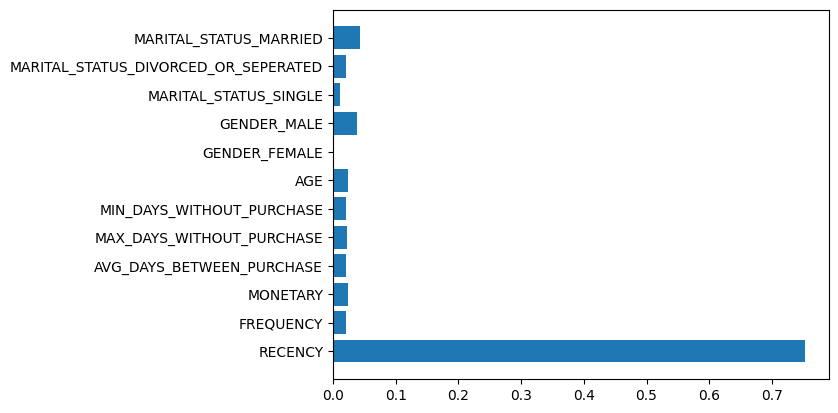

In [89]:
plt.barh(X_train.columns, xgb_improved.feature_importances_)

# 6. Model Comparison

## 6.1 Model Accuracies

In [90]:
evaluateModelWithName(log_ref_before,'log_ref_before')
evaluateModelWithName(log_ref_improved,'log_ref_improved')
print('\n')

evaluateModelWithName(decision_tree_before,'decision_tree_before')
evaluateModelWithName(decision_tree_improved,'decision_tree_improved')
print('\n')

evaluateModelWithName(random_forest_before,'random_forest_before')
evaluateModelWithName(random_forest_improved,'rdm_fst_improved')
print('\n')

evaluateModelWithName(adb_before,'adb_before')
evaluateModelWithName(adb_improved,'adb_improved')
print('\n')

evaluateModelWithName(xgb_before,'xgb_before')
evaluateModelWithName(xgb_improved,'xgb_improved')

log_ref_before
Train Accuracy: 	77.50%            
Test Accuracy: 		76.79%            
Holdout Accuracy: 	76.67%
log_ref_improved
Train Accuracy: 	77.45%            
Test Accuracy: 		76.78%            
Holdout Accuracy: 	76.65%


decision_tree_before
Train Accuracy: 	95.31%            
Test Accuracy: 		70.15%            
Holdout Accuracy: 	70.66%
decision_tree_improved
Train Accuracy: 	78.36%            
Test Accuracy: 		77.06%            
Holdout Accuracy: 	77.03%


random_forest_before
Train Accuracy: 	100.00%            
Test Accuracy: 		76.42%            
Holdout Accuracy: 	76.43%
rdm_fst_improved
Train Accuracy: 	78.87%            
Test Accuracy: 		77.35%            
Holdout Accuracy: 	77.35%


adb_before
Train Accuracy: 	100.00%            
Test Accuracy: 		68.43%            
Holdout Accuracy: 	68.82%
adb_improved
Train Accuracy: 	77.92%            
Test Accuracy: 		77.29%            
Holdout Accuracy: 	77.31%


xgb_before
Train Accuracy: 	95.18%            
Test Accuracy: 		75.0

In [84]:
#View Cross Validation Score
print('Logistic Regression Cross Validation Accuracy: {:.2f}%'.format(lr_best_score*100))
print('Decision Tree Cross Validation Accuracy: {:.2f}%'.format(dt_best_score*100))
print('Random Forest Cross Validation Accuracy: {:.2f}%'.format(rf_best_score*100))
print('Ada Boost Cross Validation Accuracy: {:.2f}%'.format(adb_best_score*100))
print('XGBoost Cross Validation Accuracy: {:.2f}%'.format(xgb_best_score*100))

Logistic Regression Cross Validation Accuracy: 77.44%
Decision Tree Cross Validation Accuracy: 77.90%
Random Forest Cross Validation Accuracy: 77.95%
Ada Boost Cross Validation Accuracy: 77.91%
XGBoost Cross Validation Accuracy: 77.96%


The chosen model will be XGBoost as has the highest accuracy with the lowest overfit. While random forest on occasion (Keeps giving different hyper parameters during Grid Search) may have higher accuracies and lower overfit, it is seen that XGBoost is far more consistent and reproducible. For this reason, XGBoost will be chosen over the other models despite sometimes getting worse results. 

# 7. Machine-Learning with Snowflake 

Now that we have finish preparing our data, performed grid search to find the best hyper parameters and chosen the final model, XGBoost. Lets see how we are able to make use of Snowflake's compute and storage to train, store, and evaluate our model.

## 7.1 Create the Stage 
We will use this stage to host user-defined functions, stored procedures, and model files on Snowflake.

In [85]:
# Create stage
session.sql("CREATE STAGE IF NOT EXISTS model_stage").collect()

[Row(status='MODEL_STAGE already exists, statement succeeded.')]

## 7.2 Create Tables

In [86]:
# Lets get out train, test and holdout tables such that we are able to evaluate the models performance on them later
train_table = session.table(name="train_table")
test_table=session.table(name="test_table")
holdout_table=session.table(name='holdout_table')

## 7.3 Create a Stored Procedure for Model Training

**Step 1: Create a Function for Training a Model**

This function trains a XGBoost classification model and saves the model to a stage. 

In [87]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_train_xgboost_model(session: Session, 
                              training_table: str, 
                              feature_cols: list,
                              target_col: str,
                              model_name: str) -> T.Variant:
    from joblib import dump
    import os
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # Actual model training
    from xgboost import XGBClassifier
    xgbmodel = XGBClassifier(learning_rate= 0.2, max_depth= 4, n_estimators= 20, subsample= 0.6)
    xgbmodel.fit(X,y)
    
    # Getting model coefficients
    feat_importance = pd.DataFrame(xgbmodel.feature_importances_,feature_cols,columns=['FeatImportance']).to_dict()

    # Save model as file and upload to Snowflake stage
    model_file = os.path.join('/tmp', model_name)
    dump(xgbmodel, model_file)
    session.file.put(model_file, '@MODEL_STAGE', auto_compress=False, overwrite=True)

    return feat_importance

**Step 2. Register the Function on Snowflake**<br>
To register the function on Snowflake as a stored procedure, specify what Python packages are required in the function. Here we specify:
- Snowpark (for uploading the saved model file to the stage)
- xgboost (for training our model)
- Joblib (for creating a model file)

In [88]:
# Registering the function as a Stored Procedure
sproc_xgboost_model = session.sproc.register(func=sproc_train_xgboost_model, 
                                            name='sproc_train_xgboost_model', 
                                            is_permanent=True, 
                                            replace=True, 
                                            stage_location='@MODEL_STAGE', 
                                            packages=[f'snowflake-snowpark-python==1.3.0'
                                                      ,f'xgboost==1.7.3'
                                                      ,f'joblib==1.1.1'])

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment


## 7.4 Model Training 

Run your Stored Procedure to train an XGBoost Model

In [89]:
#Specify inputs
training_table = "frostbyte_tasty_bytes.analytics.train_table"
# get feature columns
feature_cols = train_table.drop('Churned').columns
target_col = 'CHURNED'
model_name = 'xgboost_model.sav'

feature_importance = sproc_xgboost_model(training_table, 
                                         feature_cols, 
                                         target_col,
                                         model_name, 
                                         session=session)

feature_importance = pd.DataFrame(eval(feature_importance))

In [90]:
# View Feature Importance
feature_importance.sort_values('FeatImportance',ascending=False)

,FeatImportance
RECENCY,0.753289
MARITAL_STATUS_MARRIED,0.043293
GENDER_MALE,0.038238
MONETARY,0.024164
AGE,0.023377
MAX_DAYS_WITHOUT_PURCHASE,0.022426
MARITAL_STATUS_DIVORCED_OR_SEPERATED,0.021539
FREQUENCY,0.021355
MIN_DAYS_WITHOUT_PURCHASE,0.020799
AVG_DAYS_BETWEEN_PURCHASE,0.020061


 The feature "RECENCY" has the highest importance with a value of 0.753289. This suggests that the recency of a customer's interaction or purchase history has the most significant impact on predicting churn.

In [91]:
# The model is now stored in a Snowflake stage
pd.DataFrame(session.sql('LIST @MODEL_STAGE').collect())

,name,size,md5,last_modified
0,model_stage/xgboost_model.sav,33840,037758e5f50c5812618acfbda67eb9f2,"Tue, 20 Jun 2023 04:33:53 GMT"


## 7.5 Model Deployment

### 7.5.1 Create a User-Defined Function for Model Inference
**Step 1: Create a Function for Model Inference**

Now that our model is built lets deploy it by creating a User defined function for model inference.  The function we created over here is to load the saved model and predict the target variable from the input features. The cache tools is also used to cache the model that is returned from the load model function. This is to ensure that the model is loaded once per user defined function call instead of each row or batch in the data.

In [92]:
# Function to load the model from file and cache the result
@cached(cache={})
#Load model
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

#Get predictions
def udf_score_xgboost_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'xgboost_model.sav'
    model = load_model(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

**Step 2. Register the Function on Snowflake**<br>

To register the function on Snowflake as a user-defined function, we specify the Python packages required. Here we specify:
- xgboost (for making predictions)
- Joblib (for loading the model from file)
- Cachetools (for caching the loaded model)

In [93]:
# Register UDF
udf_score_xgboost_model_vec_cached = session.udf.register(func=udf_score_xgboost_model_vec_cached, 
                                                                   name="udf_score_xgboost_model", 
                                                                   stage_location='@MODEL_STAGE',
                                                                   input_types=[T.FloatType()]*len(feature_cols),
                                                                   return_type = T.FloatType(),
                                                                   replace=True, 
                                                                   is_permanent=True, 
                                                                   imports=['@MODEL_STAGE/xgboost_model.sav'],
                                                                   packages=[f'xgboost==1.7.3'
                                                                             ,f'joblib==1.1.1'
                                                                             ,f'cachetools==4.2.2'], 
                                                                   session=session)

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package cachetools in the local environment is 5.3.0, which does not fit the criteria for the requirement cachetools==4.2.2. Your UDF might not work when the package version is different between the server and your local environment


### 7.5.2 Run UDF

#### 7.5.1 Evaluation

In [94]:
# Scoring train, test and holdout data with scalar UDF but caching the model
train_pred=train_table.with_column('PREDICTION', udf_score_xgboost_model_vec_cached(*feature_cols))
test_pred = test_table.with_column('PREDICTION', udf_score_xgboost_model_vec_cached(*feature_cols))
holdout_pred=holdout_table.with_column('PREDICTION', udf_score_xgboost_model_vec_cached(*feature_cols))

In [95]:
# Train evaluation accuracy
train_accuracy = train_pred.filter(F.col("CHURNED") == F.col("PREDICTION")).count() / train_pred.count()
test_accuracy = test_pred.filter(F.col("CHURNED") == F.col("PREDICTION")).count() / test_pred.count()
holdout_accuracy = holdout_pred.filter(F.col("CHURNED") == F.col("PREDICTION")).count() / holdout_pred.count()

print("Training data accuracy: {:.2f}%".format(train_accuracy*100))
print("Testing data accuracy: {:.2f}%".format(test_accuracy*100))
print("Holdout data accuracy: {:.2f}%".format(holdout_accuracy*100))

Training data accuracy: 78.43%
Testing data accuracy: 77.26%
Holdout data accuracy: 77.26%


In [96]:
# Create Classification Report
class_report_test=test_pred.to_pandas()
# Get the predicted labels and actual labels as NumPy arrays
y_pred = class_report_test['PREDICTION'].values
y_true = class_report_test['CHURNED'].values

# Print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      6383
           1       0.73      0.87      0.79      6414

    accuracy                           0.77     12797
   macro avg       0.78      0.77      0.77     12797
weighted avg       0.78      0.77      0.77     12797



A Churn class Recall of 0.87 means that the model was able to catch 87% of the actual Churn cases. This is the measure we really care about, because we want to miss as few of the true Churn cases as possible.

Precision of the Churn class measures how often the model catches an actual Churn case, while also factoring in how often it misclassifies a Non-Churn case as a Churn case. In this case, a Churn Precision of 0.73 is not a problem because there are no significant consequences of identifying a customer as a Churn risk when he/she isn’t.

The F1 Score is the harmonic mean of Precision and Recall. It helps give us a balanced idea of how the model is performing on the Churn class. In this case a Churn Class F1 Score of 0.79 is not bad but could be perhaps be improved on. 

## Next Steps

![Next_Steps.png](assets/Next_Steps.png)

We've created features, built a XGBoost model, and deployed it - all with Snowflake. What else can we do from here? <br>
### 1. Add new features from Snowflake Data Marketplace

### 2. Use a User-Defined Table Functions(UDTF) for parallel hyperparameter tuning instead to perform more in-depth GridSearch 

### 3. Automate predictions with Streams & Tasks

### 4. Create an app interface with Streamlit for Marketing and Sales Team to get customer churn predictions and key visualizations

## Reset

In [97]:
# Scale down compute
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()